## LIBRERÍAS

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## CARGA DEL DATASET

In [4]:
# se carga el dataset en la variable bankdata
bankdata = pd.read_csv('bank_subscription.csv', sep=';')
bankdata.sample(5)

,Age,Job,Marital Status,Education,Credit,Balance (euros),Housing Loan,Personal Loan,Contact,Last Contact Day,Last Contact Month,Last Contact Duration,Campaign,Pdays,Previous,Poutcome,Subscription
10561,56.0,retired,married,tertiary,NaN,3708.0,no,no,unknown,16,jun,210.0,2,-1.0,0,unknown,0
20329,31.0,blue-collar,married,secondary,no,-204.0,yes,yes,cellular,11,aug,NaN,7,-1.0,0,unknown,0
36711,41.0,admin.,divorced,secondary,no,1634.0,yes,yes,cellular,12,may,16.0,5,NaN,0,unknown,0
37974,27.0,housemaid,married,NaN,no,NaN,yes,no,cellular,14,may,196.0,2,-1.0,0,unknown,0
24849,48.0,management,married,tertiary,no,2266.0,no,no,cellular,18,nov,676.0,1,-1.0,0,unknown,1


### Split del dataset en set "Train" y "Test"

In [6]:
# variable a predecir (target)
y = bankdata['Subscription']

# variables predictoras (features)
x = bankdata.drop(columns=['Subscription'])

# Train Test Split
semilla = 42
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.80, random_state=semilla)

### Variables categóricas y numéricas

In [8]:
# variables numericas
variables_num = list(x.select_dtypes(include='number').columns)

# variables categoricas
variables_cat = list(x.select_dtypes(include='object').columns)

print(f'Variables numéricas:\n{variables_num}')
print(f'\nVariables categóricas:\n{variables_cat}')

Variables numéricas:
['Age', 'Balance (euros)', 'Last Contact Day', 'Last Contact Duration', 'Campaign', 'Pdays', 'Previous']

Variables categóricas:
['Job', 'Marital Status', 'Education', 'Credit', 'Housing Loan', 'Personal Loan', 'Contact', 'Last Contact Month', 'Poutcome']


## PIPELINE 1: SIN PCA

Se define la función con el preprocesamiento que se utilizará dentro del pipeline para imputar los nulos y hacer ajustes en las variables númericas.

In [11]:
def preprocesamiento_datos(bankdata):
    # Manejo de variables numericas
    mask_pdays_1 = bankdata['Pdays'] == -1
    bankdata.loc[mask_pdays_1, 'Pdays'] = bankdata['Pdays'].max()
    
    bankdata_clean = bankdata.copy() # df con modificaciones
    
    # Imputacion de nulos
    
    # Pdays
    bankdata_clean['Pdays'] = bankdata_clean['Pdays'].fillna(bankdata['Pdays'].max())
    # Last Contact Duration
    bankdata_clean['Last Contact Duration'] = bankdata_clean['Last Contact Duration'].fillna(bankdata['Last Contact Duration'].median())
    # Balance (euros)
    bankdata_clean['Balance (euros)'] = bankdata_clean['Balance (euros)'].fillna(bankdata['Balance (euros)'].median())
    # Job
    bankdata_clean['Decil Balance (euros)'] = pd.qcut(bankdata_clean['Balance (euros)'], 10, labels=False)
    bankdata_clean['Job'] = bankdata_clean['Job'].fillna(bankdata_clean.groupby('Decil Balance (euros)')['Job'].transform(lambda x: x.mode()[0]))
    # Education
    bankdata_clean['Education'] = bankdata_clean['Education'].fillna(bankdata_clean.groupby('Job')['Education'].transform(lambda x: x.mode()[0]))
    # Age
    bankdata_clean['Age'] = bankdata_clean['Age'].fillna(bankdata_clean.groupby('Job')['Age'].transform('median'))
    # Marital Status
    bankdata_clean['Decil Age'] = pd.qcut(bankdata_clean['Age'], 10, labels=False)
    bankdata_clean['Marital Status'] = bankdata_clean['Marital Status'].fillna(bankdata_clean.groupby('Decil Age')['Marital Status'].transform(lambda x: x.mode()[0]))
    # Housing Loan
    bankdata_clean['Housing Loan'] = bankdata_clean['Housing Loan'].fillna(bankdata_clean.groupby('Decil Age')['Housing Loan'].transform(lambda x: x.mode()[0]))
    # Credit
    bankdata_clean['Credit'] = bankdata_clean['Credit'].fillna('no')
    # Personal Loan
    bankdata_clean['Personal Loan'] = bankdata_clean['Personal Loan'].fillna('no')

    # eliminacion de columnas auxiliares
    bankdata_clean = bankdata_clean.drop(['Decil Balance (euros)', 'Decil Age'], axis=1)
    
    return bankdata_clean

### Steps del pipeline

In [13]:
# step 1: preprocesamiento
step_1 =  FunctionTransformer(preprocesamiento_datos, validate=False)

# step 2: StandardScaler para variables numericas y OneHotEncoding para variables categoricas
step_2 = ColumnTransformer( transformers=[
                                            ('num', StandardScaler(), variables_num),  # StandardScaler sobre variables numericas
                                            ('cat', OneHotEncoder(), variables_cat)   # OneHotEncoding sobre las variables categóricas (dummies)
                                            ])
# step 3: Aplicacion del modelo. Aqui lo inicializamos con LogisticRegression() pero en GridSearch se probara SVM tambien
step_3 = LogisticRegression()

pipeline = Pipeline([
                        ('preprocesamiento', step_1),
                        ('features', step_2),
                        ("estimador", step_3)
                    ])
# visualizacion de los steps que conforman al pipeline
pipeline

Pipeline(steps=[('preprocesamiento',
                 FunctionTransformer(func=<function preprocesamiento_datos at 0x000002582E8B9BC0>)),
                ('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Balance (euros)',
                                                   'Last Contact Day',
                                                   'Last Contact Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Job', 'Marital Status',
                                                   'Education', 'Credit',
                                                   'Housing Loan',
                                                   'Personal Loan', 'Contact',
                                                   'Last Contact Month',
                                                   'Poutcome'])])),
                ('estimador', LogisticRegression())])

### Entrenamiento de modelos e hiperparámetros utilizando el pipeline con GridSearch y CrossValidation (GSCV)

Al tratarse de un problema de clasificación donde se quiere predecir si un cliente se va a subscribir o no a una campaña de marketing, los modelos a probar serán: 
- **Regresión Logística**
- **Support Vector Machine**

In [16]:
# modelos e hiperparametros a probar con GSCV
parametros = [
                {   # Regresio logística
                    "estimador": (LogisticRegression(),),
                    "estimador__C": (100,10, 1)
                }, 
    
                {
                    "estimador": (SVC(probability=True),),
                    "estimador__kernel":['rbf'], 
                    "estimador__C":(5, 50, 500), 
                    "estimador__gamma":( 0.1, 0.01, 0.001)          
                }
            ]

# se define el GSCV: 
grid_search = GridSearchCV( pipeline, 
                            parametros,
                            refit = True, # para que devuelva el modelo con los mejores parametros encontrados 
                            cv = 3, # cantidad de folds
                            verbose=1,
                            n_jobs=-1)

# entrenamiento los modelos con GSCV para encontrar al mejor
grid_search.fit(xtrain, ytrain.values.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        FunctionTransformer(func=<function preprocesamiento_datos at 0x000002582E8B9BC0>)),
                                       ('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Balance '
                                                                          '(euros)',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Day',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Duration',
                                                                          'Campaign',
                                                                          'Pdays',
                                                                          'Previous']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Job',
                                                                          'Ma...
                                                                          'Credit',
                                                                          'Housing '
                                                                          'Loan',
                                                                          'Personal '
                                                                          'Loan',
                                                                          'Contact',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Month',
                                                                          'Poutcome'])])),
                                       ('estimador', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'estimador': (LogisticRegression(),),
                          'estimador__C': (100, 10, 1)},
                         {'estimador': (SVC(probability=True),),
                          'estimador__C': (5, 50, 500),
                          'estimador__gamma': (0.1, 0.01, 0.001),
                          'estimador__kernel': ['rbf']}],
             verbose=1)

### Resultados: Métricas

In [18]:
# obtengo las caracteristicas del mejor modelo obtenido 
grid_search.best_params_

{'estimador': LogisticRegression(), 'estimador__C': 1}

Como resultado del pipeline sin PCA utilizando GSCV se obtuvo que el mejor modelo para predecir fue el de **Regresión Logística** con un parámtro **C (costo) = 10**.

In [20]:
# obtengo el accuracy en train del mejor modelo
aucc_train_1 = round(grid_search.best_score_, 4)

# prediccion sobre las muestras de test utilizando el mejor modelo
ypred = grid_search.predict(xtest)

# calculo del acuracy en test (comparacion de ytest vs ypred)
test_acc_1 = round(accuracy_score(ytest, ypred),4)

# calculo del area (AUC) sobre la curva ROC
yproba = grid_search.predict_proba(xtest)
fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
auc_value_1 = round(auc(fpr1, tpr1),4)

# calculo de sensitivity y specificity con matriz de coconfusion de coconfusion
matriz_confusion_1 = confusion_matrix(ytest, ypred)
sensitivity_subscripcion_1 = round(matriz_confusion_1[1,1] / (matriz_confusion_1[1,0] + matriz_confusion_1[1,1]) , 4)
specificity_no_subscripcion_1 = round(matriz_confusion_1[0,0] / (matriz_confusion_1[0,0] + matriz_confusion_1[0,1]) , 4)

# guardo los resultados en un dataframe
resultados = pd.DataFrame({'Modelo sin PCA' : {'Accuracy train':aucc_train_1, 'Accuracy test':test_acc_1, 'AUC':auc_value_1, 'Sensitivity':sensitivity_subscripcion_1, 'Specificity':specificity_no_subscripcion_1 }})
resultados

,Modelo sin PCA
Accuracy train,0.9017
Accuracy test,0.8999
AUC,0.8762
Sensitivity,0.3230
Specificity,0.9763


**Observaciones:**
- Tanto el accuracy como el AUC son cercanos a 1, con lo cual en principio parece ser que el modelo hace una buena predicción de la variable subscrpción.
- El accuracy en train y en test es muy similar y con valores cercanos a 1, por lo que se podría decir que no hay grandes errores de Bias ni Variance.
- El specificity tiene un valor muy cercano a 1, lo que quiere decir que el modelo clasifica muy bien cuando un usuario **no se subscribe**. Contrariamente, el sensitivity tiene un valor muy bajo y esto quiere decir que el modelo no está logrando detectar de forma acertada a los usuarios que **se subscriben**. Esto parece ser a priori por la naturaleza del dataset utilizado, ya que como se mostrará a continuación, la gran mayoria de clientes del dataset tienen subscription = 0 y esto dificulta el entrenamiento del modelo a la hora de detectar la clase subscription = 0.

In [22]:
# proporicon de clases en Subscription
bankdata['Subscription'].value_counts() / bankdata.shape[0] * 100

Subscription
0    88.30152
1    11.69848
Name: count, dtype: float64

Aproximadamente el 88% de los clientes del dataset tienen subscrption = 0 y solo el 12% tienen subscription = 1

### Resultados: Gráficos

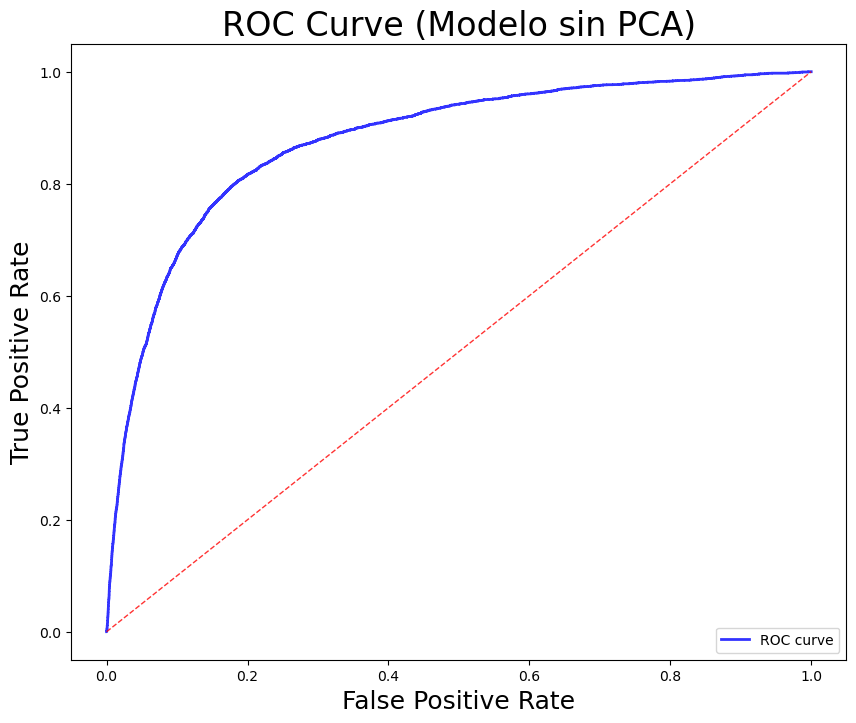

In [25]:
plt.figure(figsize = (10,8))
plt.plot(fpr1, tpr1, lw=2, alpha=0.8 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC Curve (Modelo sin PCA)',fontsize=24)
plt.show()

La forma de la curva ROC tiene una forma considerablemente más cercana a la ideal donde el área debajo de ella es igual a 1 que a la peor de las situaciones (rojo) donde la probabilidad de clasificar bien es del 50% (igual que arrojar una moneda).

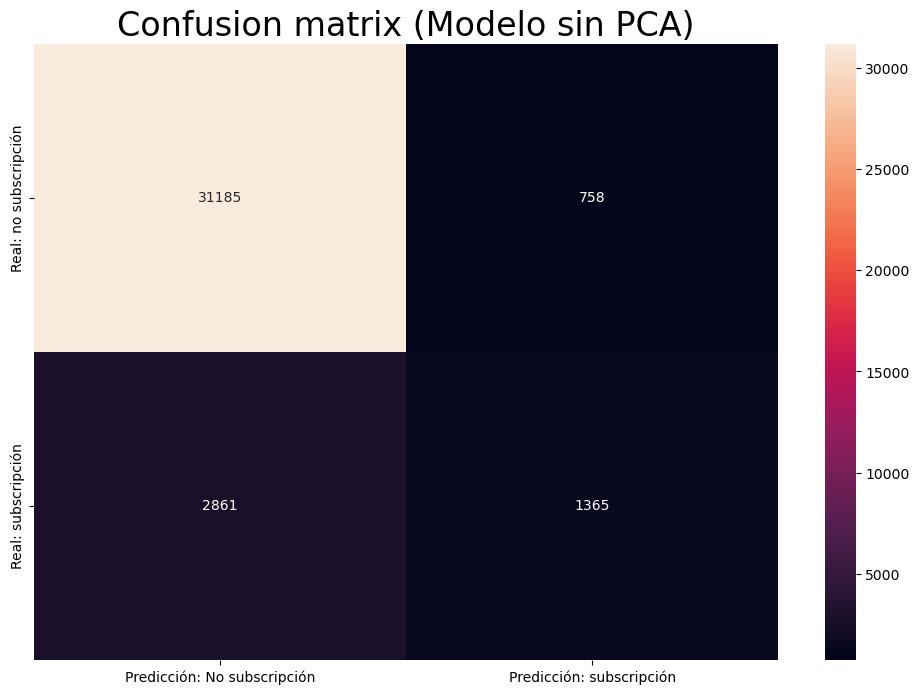

In [27]:
# Compute Confusion Matrix
cm = confusion_matrix(ytest, ypred)
df_cm = pd.DataFrame(cm,index = ['Real: no subscripción', 'Real: subscripción'], columns = ['Predicción: No subscripción', 'Predicción: subscripción'])
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.title('Confusion matrix (Modelo sin PCA)',fontsize=24)
plt.show()

Se puede visualizar que la gran mayoria de las predicciones se encuentran en la diagonal conformada por los **True positive** y **True Negative**, lo cual habla de un **buen accuracy** del modelo encontrado. Pero también se evidencia un **Sensitivity bajo**, que tal y como se mencionó anteriormente, quiere decir que el modelo no clasifica de forma acertiva a las "subscripciones"

## PIPELINE 2: CON PCA

### Steps del pipeline

In [31]:
# step 1: preprocesamiento
step_1 =  FunctionTransformer(preprocesamiento_datos, validate=False)

# step 2: StandardScaler para variables numericas y OneHotEncoding para variables categoricas
step_2 = ColumnTransformer( transformers=[
                                            ('num', StandardScaler(), variables_num),  # StandardScaler sobre variables numericas
                                            ('cat', OneHotEncoder(), variables_cat)   # OneHotEncoding sobre las variables categóricas (dummies)
                                            ])
# step 3: Aplicacion del modelo. Aqui lo inicializamos con LogisticRegression() pero en GridSearch se probara SVM tambien
step_3 = LogisticRegression()

# step 4: reduccion de la dimensionalidad con n_components = 10
step_4 = PCA(n_components= 10)

pipeline_pca =Pipeline([
                        ('preprocesamiento', step_1),
                        ('features', step_2),
                        ("reducciondim", step_4),
                        ("estimador", step_3)

                    ])
# visualizacion de los steps que conforman al pipeline
pipeline_pca

Pipeline(steps=[('preprocesamiento',
                 FunctionTransformer(func=<function preprocesamiento_datos at 0x000002582E8B9BC0>)),
                ('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Balance (euros)',
                                                   'Last Contact Day',
                                                   'Last Contact Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Job', 'Marital Status',
                                                   'Education', 'Credit',
                                                   'Housing Loan',
                                                   'Personal Loan', 'Contact',
                                                   'Last Contact Month',
                                                   'Poutcome'])])),
                ('reducciondim', PCA(n_components=10)),
                ('estimador', LogisticRegression())])

### Entrenamiento de modelos e hiperparámetros utilizando el pipeline con GridSearch y CrossValidation (GSCV)

In [74]:
# modelos e hiperparametros a probar con GSCV
parametros = [
                {
                    "estimador": (LogisticRegression(),),
                    "estimador__C": (0.1,1,10)
                }, 
            
                {
                    "estimador": (SVC(probability=True),),
                    "estimador__kernel":['linear'], 
                    "estimador__C":(1, 5, 10), 
                    "estimador__gamma":( 0.1, 0.01)          
                }
            ]
    

# creamos el GSCV: 
grid_search_pca = GridSearchCV( pipeline_pca, 
                                parametros,
                                refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                                cv = 3, # cv indica la cantidad de folds
                                verbose=1,
                                n_jobs=-1)

# entrenamiento los modelos con GSCV para encontrar al mejor
grid_search_pca.fit(xtrain, ytrain.values.ravel())

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        FunctionTransformer(func=<function preprocesamiento_datos at 0x000002582E8B9BC0>)),
                                       ('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Balance '
                                                                          '(euros)',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Day',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Duration',
                                                                          'Campaign',
                                                                          'Pdays',
                                                                          'Previous']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Job',
                                                                          'Ma...
                                                                          'Loan',
                                                                          'Contact',
                                                                          'Last '
                                                                          'Contact '
                                                                          'Month',
                                                                          'Poutcome'])])),
                                       ('reducciondim', PCA(n_components=10)),
                                       ('estimador', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'estimador': (LogisticRegression(),),
                          'estimador__C': (0.1, 1, 10)},
                         {'estimador': (SVC(probability=True),),
                          'estimador__C': (1, 5, 10),
                          'estimador__gamma': (0.1, 0.01),
                          'estimador__kernel': ['linear']}],
             verbose=1)

### Resultados: Métricas

In [76]:
# obtengo las caracteristicas del mejor modelo obtenido 
grid_search_pca.best_params_

{'estimador': LogisticRegression(), 'estimador__C': 10}

Como resultado del pipeline con PCA (n_components = 10) utilizando GSCV se obtuvo que el mejor modelo para predecir fue el de **Regresión Logística** con un parámtro **C (costo) = 10**.

**Aclaración:** El n_compontents = 10 se definió luego de probar distintos valores tales como 5,15,20,25, 30 y 40. EL valor de 10 es el que mantiene un buen accuracy, similar al modelo sin PCA, pero utilizando solo el 62% de las columnas del dataset "bankdata" original (tiene 16 sin contar la variable target).

In [78]:
# obtengo el accuracy en train del mejor modelo
aucc_train_2 = round(grid_search_pca.best_score_, 4)

# prediccion sobre las muestras de test utilizando el mejor modelo
ypred_2 = grid_search_pca.predict(xtest)

# calculo del acuracy en test (comparacion de ytest vs ypred_2)
test_acc_2 = round(accuracy_score(ytest, ypred_2),4)

# calculo del area (AUC) sobre la curva ROC
yproba = grid_search_pca.predict_proba(xtest)
fpr2, tpr2, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
auc_value_2 = round(auc(fpr2, tpr2),4)

# calculo de sensitivity y specificity con matriz de coconfusion de coconfusion
matriz_confusion_2 = confusion_matrix(ytest, ypred_2)
sensitivity_subscripcion_2 = round(matriz_confusion_2[1,1] / (matriz_confusion_2[1,0] + matriz_confusion_2[1,1]) , 4)
specificity_no_subscripcion_2 = round(matriz_confusion_2[0,0] / (matriz_confusion_2[0,0] + matriz_confusion_2[0,1]) , 4)

resultados['Modelo con PCA [n=10]'] = [aucc_train_2, test_acc_2, auc_value_2, sensitivity_subscripcion_2, specificity_no_subscripcion_2]

resultados

,Modelo sin PCA,Modelo con PCA [n=10]
Accuracy train,0.9017,0.8952
Accuracy test,0.8999,0.8897
AUC,0.8762,0.8394
Sensitivity,0.3230,0.1841
Specificity,0.9763,0.9830


**Observaciones:**
- Con un 62% de las columnas del dataset original, el modelo con PCA obtiene valores de **accuracy muy similares** a los alcanzados por el modelo sin PCA.
- A pesar de que la diferencia entre el accuracy en train y test del modelo con PCA es mayor a la del modelo sin PCA, esta sigue siendo poco significativa. Por ende, se podría decir que este modelo tampoco tiene grandes errores por Bias y Variance.
- El **área AUC bajo la curva ROC del modelo con PCA es siginifcativamente menor a la de la del modelo sin PCA**. Esto quiere decir, que el modelo con PCA clasifica peor a medida que la función del clasificador encontrado se mueve en la dirección de alguna de las clases de la variable Subscription (variable target).
- En línea con el punto anterior, se puede observar que si bien el modelo con PCA tiene un **specificity levemente superior** que el modelo sin PCA, el **sensitivity es considerablemente peor**. Puntualmente, es practicamente un 50% menor al modelo sin PCA, y esto quiere decir, que el modelo con PCA es peor a la hora de identificar si un cliente tendrá Subscription = 1.

### Resultados: Gráficos

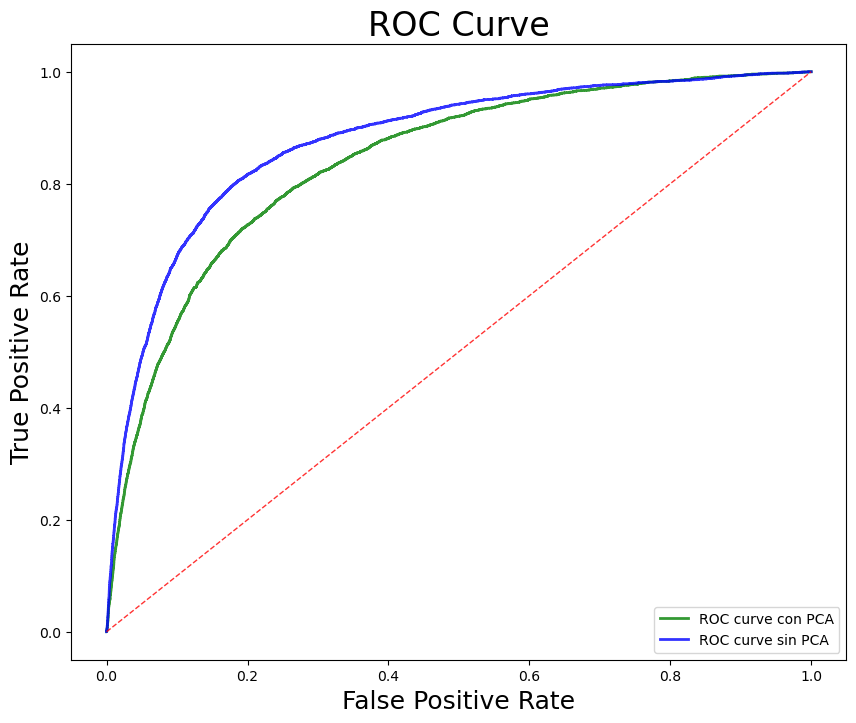

In [81]:
# grafico de curva ROC del modelo con PCA y sin PCA
plt.figure(figsize = (10,8))
plt.title('ROC Curve',fontsize=24)

plt.plot(fpr2, tpr2, lw=2, alpha=0.8 , label = 'ROC curve con PCA', color = 'g')
plt.plot(fpr1, tpr1, lw=2, alpha=0.8 , label = 'ROC curve sin PCA', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)

plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.legend(loc="lower right")

La curva ROC de ambos modelos es similar y más cercana a la ideal que a la peor solución (roja). Aun así, se puede observar que **es mejor la curva ROC del modelo sin PCA que la del modelo con PCA**.

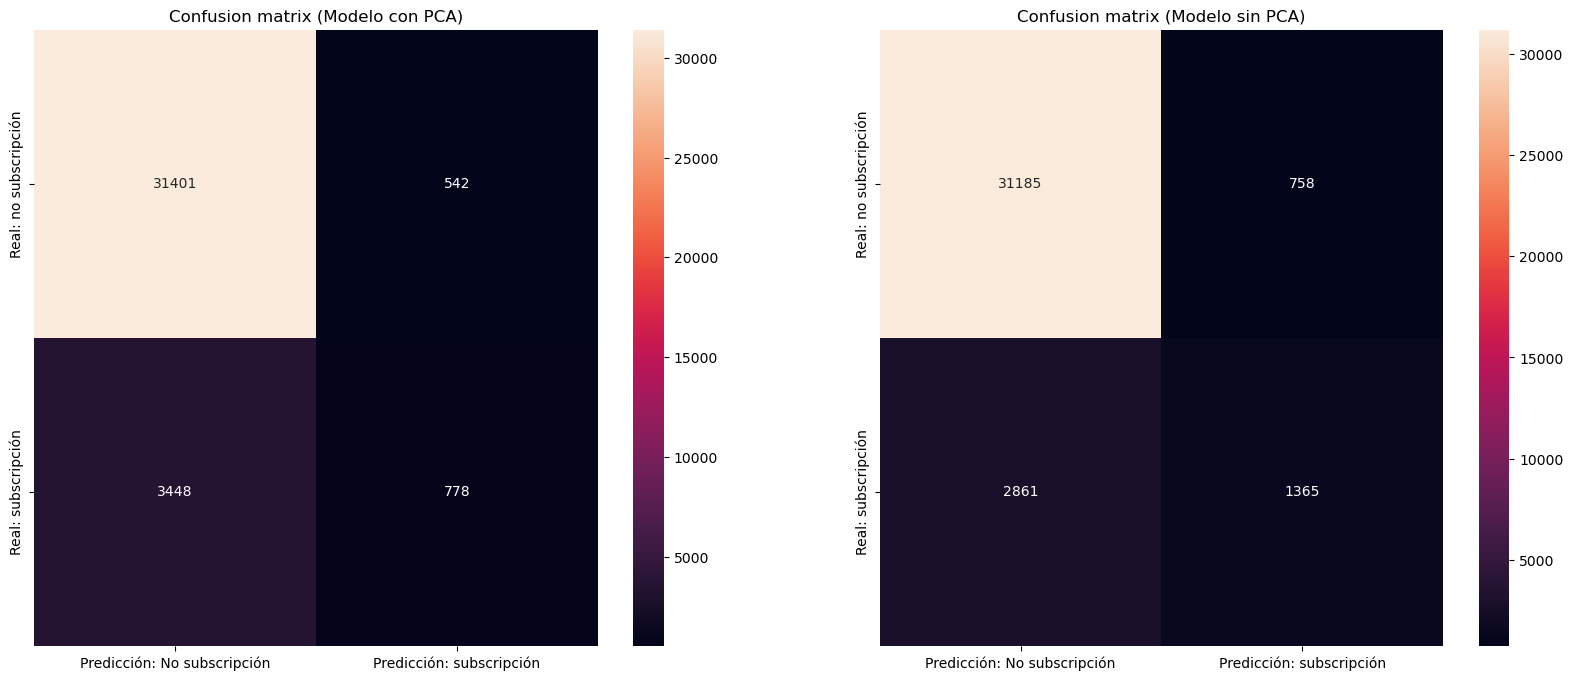

In [83]:
# contruccion de matriz de confusion
cm_2 = confusion_matrix(ytest, ypred_2)
df_cm_2 = pd.DataFrame(cm_2,index = ['Real: no subscripción', 'Real: subscripción'], columns = ['Predicción: No subscripción', 'Predicción: subscripción'])

# grafico de la matriz de confusion del modelo sin PCA y con PCA
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

axes[0].set_title('Confusion matrix (Modelo con PCA)')
sns.heatmap(df_cm_2, annot=True,fmt='g', ax=axes[0])

axes[1].set_title('Confusion matrix (Modelo sin PCA)')
sns.heatmap(df_cm, annot=True,fmt='g', ax=axes[1])
plt.show()

En ambas matirces de confusión se puede observar un buen accuracy porque en su diagonal True positive y False positive se encuentran la mayoria de las predicciones. Por otro lado, viendo el **Sensitivity**, es notoria la diferencia entre el modelo sin PCA y con PCA. Este último, tiene practicamente la mitad de predicciones en la ubicación False positive de la matriz y por ende como se mencionó anteriormente, esto quiere decir que **detecta de peor manera a las Subscription = 1**.

## CONCLUSIÓN

Luego de haber entrenado y analizado las métricas de los modelos de clasificación con y sin reducción de la dimensionalidad (PCA). Concluimos en que el mejor modelo que se ha encontrado para realizar la predicción de la variable categórica "Subscription" es el de **Regresión Logística con hiperparámetro C(costo) de 10 y sin aplicar PCA**. Dicha concluisión surge por los siguientes motivos:
- El **accuraccy** del modelo sin PCA alzanzó un valor en test superior al modelo con PCA (0.900 vs 0.889).
- El modelo con PCA alzanzó un accuraccy similar al modelo sin PCA, utilizando un 62% de las features del dataset original, lo que lo vuelve un modelo más "liviano" para llevar a producción. A pesar de ello, también tuvo un **Sensitivity** aproximadamente un 50% menor al del modelo sin PCA (0.187 vs 0.327), lo que lo vuelve considerablemente peor a la hora de identificar valores de Subscription = 1. Es por ello, que concluimos en que la ventaja del modelo con PCA dada por ser un modelo más liviano, no compensa el hecho de que genera peores predicciones que el modelo sin PCA.